# Backtesting with zipline - Pipeline API with Custom Data

## Imports & Settings

In [129]:
from collections import defaultdict
from time import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [130]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [131]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [132]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [133]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 20

## Load Data

### Quandl Wiki Bundel

In [134]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [135]:
def load_predictions(bundle):
    predictions = (pd.read_hdf('data/predictions.h5', 'lgb/train/01')
                   .append(pd.read_hdf('data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))
    predictions = (predictions.loc[~predictions.index.duplicated()]
                   .iloc[:, :10]
                   .mean(1)
                   .sort_index()
                   .dropna()
                  .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [136]:
predictions, assets = load_predictions(bundle_data)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 745975 entries, (A, 2015-01-02 00:00:00) to (ZION, 2017-12-28 00:00:00)
Data columns (total 1 columns):
prediction    745975 non-null float64
dtypes: float64(1)
memory usage: 8.6+ MB
None


In [137]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2015-01-02 to 2017-12-28
Columns: 995 entries, 0 to 3188
dtypes: float64(995)
memory usage: 5.7 MB


### Define Custom Dataset

In [138]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [139]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [140]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [141]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets))

## Initialize Algorithm

In [142]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = context.shorts = 0
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [143]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    df = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1)))
    
    holdings = df[df!=0]
    other = df[df==0]
    other = other[~other.index.isin(holdings.index) & ~other.index.duplicated()]
    context.trades = holdings.append(other)
    assert len(context.trades.index.unique()) == len(context.trades)

## Define Rebalancing Logic

In [144]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    positions = context.portfolio.positions
    s=pd.Series({s:v.amount*v.last_sale_price for s, v in positions.items()}).sort_values(ascending=False)
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)
    
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
#     log.warning('{} {:,.0f}'.format(len(positions), context.portfolio.portfolio_value))
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## Record Data Points

In [145]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [146]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [147]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2015-01-02
End:   2017-12-28


In [148]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2020-02-29 22:46:03.037169]: WARNING: ensure_benchmark_data: Still don't have expected benchmark data for 'SPY' from 1989-12-29 00:00:00+00:00 to 2020-02-28 00:00:00+00:00 after redownload!
[2020-02-29 22:46:03.680812]: WARNING: ensure_treasury_data: Still don't have expected treasury data for 'SPY' from 1990-01-02 00:00:00+00:00 to 2020-02-28 00:00:00+00:00 after redownload!


Duration: 62.11s


## PyFolio Analysis

In [149]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [150]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

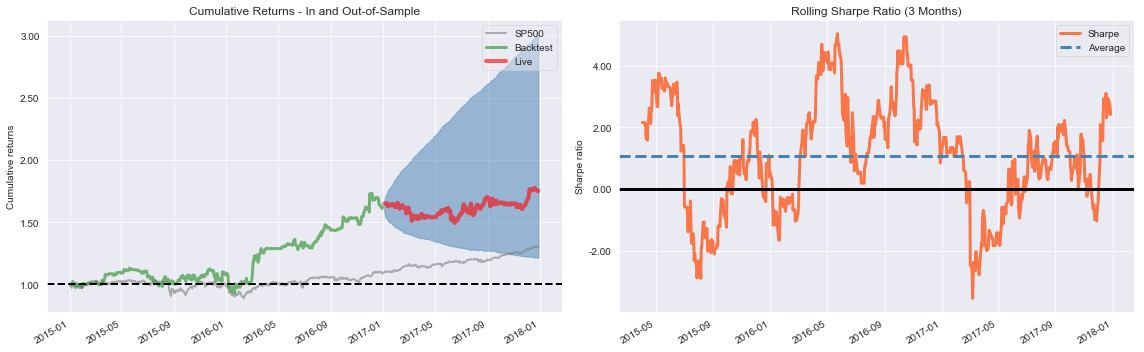

In [151]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2017-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig('figures/pyfolio_out_of_sample', dpi=300);

### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.59,2015-05-21,2016-01-20,2016-03-03,206
1,13.81,2016-12-05,2017-06-16,2017-12-07,264
2,6.04,2016-06-08,2016-06-16,2016-08-01,39
3,4.94,2016-03-14,2016-03-15,2016-03-21,6
4,4.56,2015-01-09,2015-01-29,2015-03-05,40


Stress Events,mean,min,max
Fall2015,0.10%,-1.92%,3.20%
New Normal,0.08%,-5.21%,9.35%


Top 10 long positions of all time,max
sid,
ALNY,5.98%
NKTR,5.67%
MDR,5.33%
FCX,5.24%
ATI,5.24%
TROX,5.21%
NVDA,5.07%
SM,5.07%
CLF,5.02%


Top 10 short positions of all time,max
sid,
VRX,-5.08%
FIZZ,-5.08%
INCY,-5.06%
HRTX,-4.91%
CNK,-4.84%
LEN,-4.82%
ENV,-4.81%
SSNC,-4.79%
WRB,-4.76%


Top 10 positions of all time,max
sid,
ALNY,5.98%
NKTR,5.67%
MDR,5.33%
FCX,5.24%
ATI,5.24%
TROX,5.21%
VRX,5.08%
FIZZ,5.08%
NVDA,5.07%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,22352.00,11631.00,10721.00
Percent profitable,0.50,0.48,0.51
Winning round_trips,11131.00,5616.00,5515.00
Losing round_trips,11023.00,5935.00,5088.00
Even round_trips,198.00,80.00,118.00


PnL stats,All trades,Short trades,Long trades
Total profit,$85809.27,$-7871.93,$93681.19
Gross profit,$1085009.15,$452525.02,$632484.13
Gross loss,$-999199.89,$-460396.95,$-538802.94
Profit factor,$1.09,$0.98,$1.17
Avg. trade net profit,$3.84,$-0.68,$8.74
Avg. winning trade,$97.48,$80.58,$114.68
Avg. losing trade,$-90.65,$-77.57,$-105.90
Ratio Avg. Win:Avg. Loss,$1.08,$1.04,$1.08
Largest winning trade,$3333.44,$3163.32,$3333.44
Largest losing trade,$-3381.31,$-1812.02,$-3381.31


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 19:58:31.256352,1 days 16:54:30.982804,1 days 23:18:08.629885
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,190 days 01:00:00,159 days 04:00:01,190 days 01:00:00
Shortest duration,0 days 21:00:00,0 days 21:00:00,0 days 21:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.01%
Avg returns winning,0.07%,0.06%,0.08%
Avg returns losing,-0.07%,-0.06%,-0.08%
Median returns all round_trips,0.00%,-0.00%,0.00%
Median returns winning,0.04%,0.04%,0.04%
Median returns losing,-0.04%,-0.04%,-0.04%
Largest winning trade,2.61%,1.97%,2.61%
Largest losing trade,-2.01%,-1.18%,-2.01%


Symbol stats,A,AAL,AAN,AAP,AAPL,ABC,ABMD,ABT,ACC,ACGL,ACIW,ACM,ACN,ACXM,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEL,AEO,AEP,AES,AET,AFG,AFSI,AGCO,AGN,AGNC,AGO,AHL,AIG,AIT,AIV,AIZ,AJG,AKAM,ALB,ALE,ALGN,ALK,ALKS,ALL,ALNY,ALXN,AMAT,AMD,AME,AMED,AMG,AMGN,AMP,AMT,AMTD,AMZN,AN,ANAT,ANSS,ANTM,AON,AOS,APA,APC,APD,APH,ARE,ARNC,ARRS,ARRY,ARW,ASGN,ASH,ATHN,ATI,ATO,ATR,ATVI,AVA,AVB,AVGO,AVT,AVX,AVY,AWI,AWK,AXP,AXS,AYI,AZO,AZPN,B,BA,BAC,BAH,BAX,BBBY,BBT,BBY,BC,BCO,BCPC,BDC,BDN,BDX,BECN,BEN,BG,BGCP,BID,BIDU,BIIB,BIO,BK,BKH,BLK,BLKB,BLL,BMRN,BMS,BMY,BOFI,BOH,BOKF,BP,BPOP,BR,BRKR,BRO,BSX,BWA,BXP,BXS,BYD,C,CA,CACC,CACI,CAG,CAH,CAKE,CAR,CASY,CAT,CATY,CAVM,CB,CBOE,CBRL,CBSH,CBT,CBU,CCE,CCI,CCK,CCL,CCMP,CCOI,CDNS,CE,CELG,CERN,CF,CFR,CFX,CGNX,CHD,CHDN,CHE,CHFC,CHH,CHK,CHKP,CHRW,CHTR,CI,CIEN,CIM,CINF,CIT,CL,CLF,CLGX,CLH,CLNY,CLR,CLX,CMA,CMC,CMCSA,CME,CMG,CMI,CMS,CNA,CNC,CNK,CNO,CNP,CNX,COF,COG,COHR,COL,COLB,COLM,COO,COP,COR,COST,CPA,CPB,CPRT,CPT,CR,CREE,CRI,CRL,CRM,CRS,CSCO,CSFL,CSGP,CSL,CSX,CTAS,CTL,CTSH,CTXS,CUBE,CUZ,CVBF,CVI,CVLT,CVS,CVX,CW,CXO,CXW,CY,D,DAL,DAN,DAR,DCI,DCT,DDS,DE,DECK,DEI,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISCK,DISH,DK,DKS,DLB,DLR,DLTR,DLX,DNB,DO,DOV,DOX,DPS,DPZ,DRE,DRH,DRI,DTE,DUK,DVA,DVN,DXCM,DY,EA,EBAY,EBIX,EBS,ECL,ED,EDR,EE,EEFT,EFX,EGN,EGP,EIX,EL,ELS,EME,EMN,EMR,ENR,ENS,ENTG,ENV,EOG,EPR,EQIX,EQR,EQT,ERIE,ES,ESGR,ESRX,ESS,ESV,ETFC,ETN,ETR,EV,EVR,EW,EWBC,EXAS,EXC,EXEL,EXP,EXPD,EXPE,EXPO,EXR,F,FAF,FAST,FCFS,FCNCA,FCX,FDS,FDX,FE,FFBC,FFIN,FFIV,FHN,FIBK,FICO,FIS,FISV,FITB,FIZZ,FL,FLIR,FLO,FLR,FLS,FLT,FMBI,FMC,FNB,FNF,FNGN,FOLD,FOX,FOXA,FR,FRT,FSLR,FTI,FTNT,FUL,FULT,G,GBCI,GD,GDOT,GE,GEO,GGG,GGP,GHC,GILD,GIS,GLNG,GLW,GM,GNRC,GNTX,GOLD,GOOGL,GPC,GPK,GPN,GPS,GPT,GRA,GRMN,GS,GT,GTT,GVA,GWR,GWW,H,HAE,HAIN,HAL,HALO,HAS,HBAN,HBI,HCP,HCSG,HD,HE,HEI,HELE,HES,HFC,HHC,HI,HIG,HIW,HLF,HOG,HOLX,HOMB,HON,HP,HPP,HPQ,HPT,HR,HRB,HRC,HRG,HRL,HRS,HRTX,HSIC,HST,HSY,HUM,HUN,HXL,IART,IBKC,IBKR,IBM,IBOC,ICE,ICUI,IDA,IDCC,IDTI,IDXX,IEX,IFF,IGT,IIVI,ILMN,IMMU,INCY,INGR,INTC,INTU,IP,IPG,IPGP,IR,IRM,IRWD,ISBC,ISRG,IT,ITRI,ITT,ITW,IVZ,JACK,JBHT,JBL,JBLU,JBT,JCI,JCOM,JEC,JJSF,JKHY,JLL,JNJ,JNPR,JPM,JWN,K,KAR,KBR,KEX,KEY,KFY,KIM,KLAC,KMB,KMPR,KMT,KMX,KNX,KO,KR,KRC,KRO,KS,KSS,KSU,KW,L,LAMR,LANC,LAZ,LB,LBTYA,LDOS,LEA,LECO,LEG,LEN,LFUS,LGND,LH,LHCG,LHO,LII,LKQ,LLL,LLY,LM,LMT,LNC,LNG,LNT,LOGM,LOPE,LOW,LPLA,LPX,LRCX,LSI,LSTR,LUV,LVS,LYB,LYV,M,MA,MAA,MAC,MAN,MANH,MAR,MAS,MASI,MAT,MBFI,MCD,MCHP,MCK,MCO,MCY,MD,MDCO,MDLZ,MDP,MDR,MDSO,MDT,MDU,MET,MFA,MGLN,MGM,MHK,MIDD,MKC,MKL,MKSI,MKTX,MLM,MMC,MMM,MMS,MMSI,MNST,MO,MOH,MORN,MOS,MPW,MPWR,MRK,MRO,MRVL,MS,MSA,MSCI,MSFT,MSG,MSI,MSM,MTB,MTD,MTG,MTN,MTX,MTZ,MU,MUR,MXIM,MYGN,MYL,NATI,NAV,NBIX,NBL,NCR,NDAQ,NDSN,NEE,NEM,NEOG,NEU,NFG,NFLX,NFX,NHI,NI,NJR,NKE,NKTR,NLY,NNI,NOC,NOV,NRG,NSC,NSP,NTAP,NTCT,NTRS,NUAN,NUE,NUS,NUVA,NVDA,NVR,NWE,NWL,NXST,NYCB,NYT,O,OAS,OC,ODFL,OFC,OGE,OHI,OI,OII,OKE,OLED,OLN,OMC,ONB,OPK,ORA,ORCL,ORI,ORLY,OSK,OXY,OZRK,PACW,PAG,PAY,PAYX,PB,PBCT,PCAR,PCG,PCH,PDCE,PDM,PEB,PEG,PEGA,PENN,PEP,PFE,PFG,PG,PGR,PH,PHM,PII,PKG,PKI,PLD,PLT,PM,PNC,PNFP,PNM,PNR,PNW,PODD,POL,POOL,POR,PPC,PPG,PPL,PRGO,PRI,PRU,PSA,PSB,PSMT,PTEN,PVH,PWR,PX,PXD,QCOM,QDEL,QGEN,R,RBC,RCL,RDN,RE,REG,REGN,RES,RF,RGA,RGLD,RHI,RHP,RHT,RIG,RJF,RL,RLI,RMD,RNR,ROK,ROL,ROLL,ROP,ROST,RP,RPM,RRC,RS,RSG,RTN,RYN,S,SAM,SATS,SBAC,SBGI,SBNY,SBRA,SBUX,SCCO,SCG,SCHW,SCI,SE,SEB,SEE,SEIC,SEM,SF,SFLY,SFNC,SGEN,SGMS,SHO,SHOO,SHW,SIG,SIGI,SIRI,SIVB,SIX,SJI,SJM,SKX,SKYW,SLAB,SLB,SLG,SLGN,SLM,SM,SMG,SMTC,SNA,SNH,SNPS,SNV,SNX,SO,SON,SPG,SPR,SRCL,SRE,SSD,SSNC,STE,STI,STL,STLD,STMP,STT,STWD,STX,STZ,SUI,SWK,SWKS,SWN,SWX,SXT,SYK,SYMC,SYNT,SYY,T,TAL,TAP,TCBI,TCO,TDC,TDG,TDS,TDY,TECD,TECH,TEL,TER,TEX,TFSL,TFX,TGT,THC,THG,THO,THS,TIF,TJX,TKR,TMK,TMO,TMUS,TOL,TPX,TREE,TREX,TRGP,TRI,TRMB,TRN,TROW,TROX,TRV,TSCO,TSLA,TSN,TSS,TTC,TTEK,TTWO,TWO,TXN,TXRH,TXT,TYL,UAA,UAL,UBSH,UBSI,UCBI,UDR,UFS,UGI,UHAL,UHS,ULTA,ULTI,UMBF,UMPQ,UNF,UNH,UNM,UNP,UPS,URBN,URI,USB,USG,USM,USNA,UTHR,UTX,V,VAR,VC,VFC,VG,VGR,VIAB,VLO,VLY,VMC,VMI,VMW,VNO,VOD,VR,VRNT,VRSK,VRSN,VRTX,VRX,VSAT,VSH,VTR,VVC,VZ,WAB,WAFD,WAL,WAT,WBA,W

Profitability (PnL / PnL total) per name,
symbol,
IMMU,10.11%
OAS,6.92%
GLNG,6.89%
WLL,6.26%
HRTX,4.66%
CXW,4.28%
MUR,4.16%
MDR,4.08%
TROX,3.95%


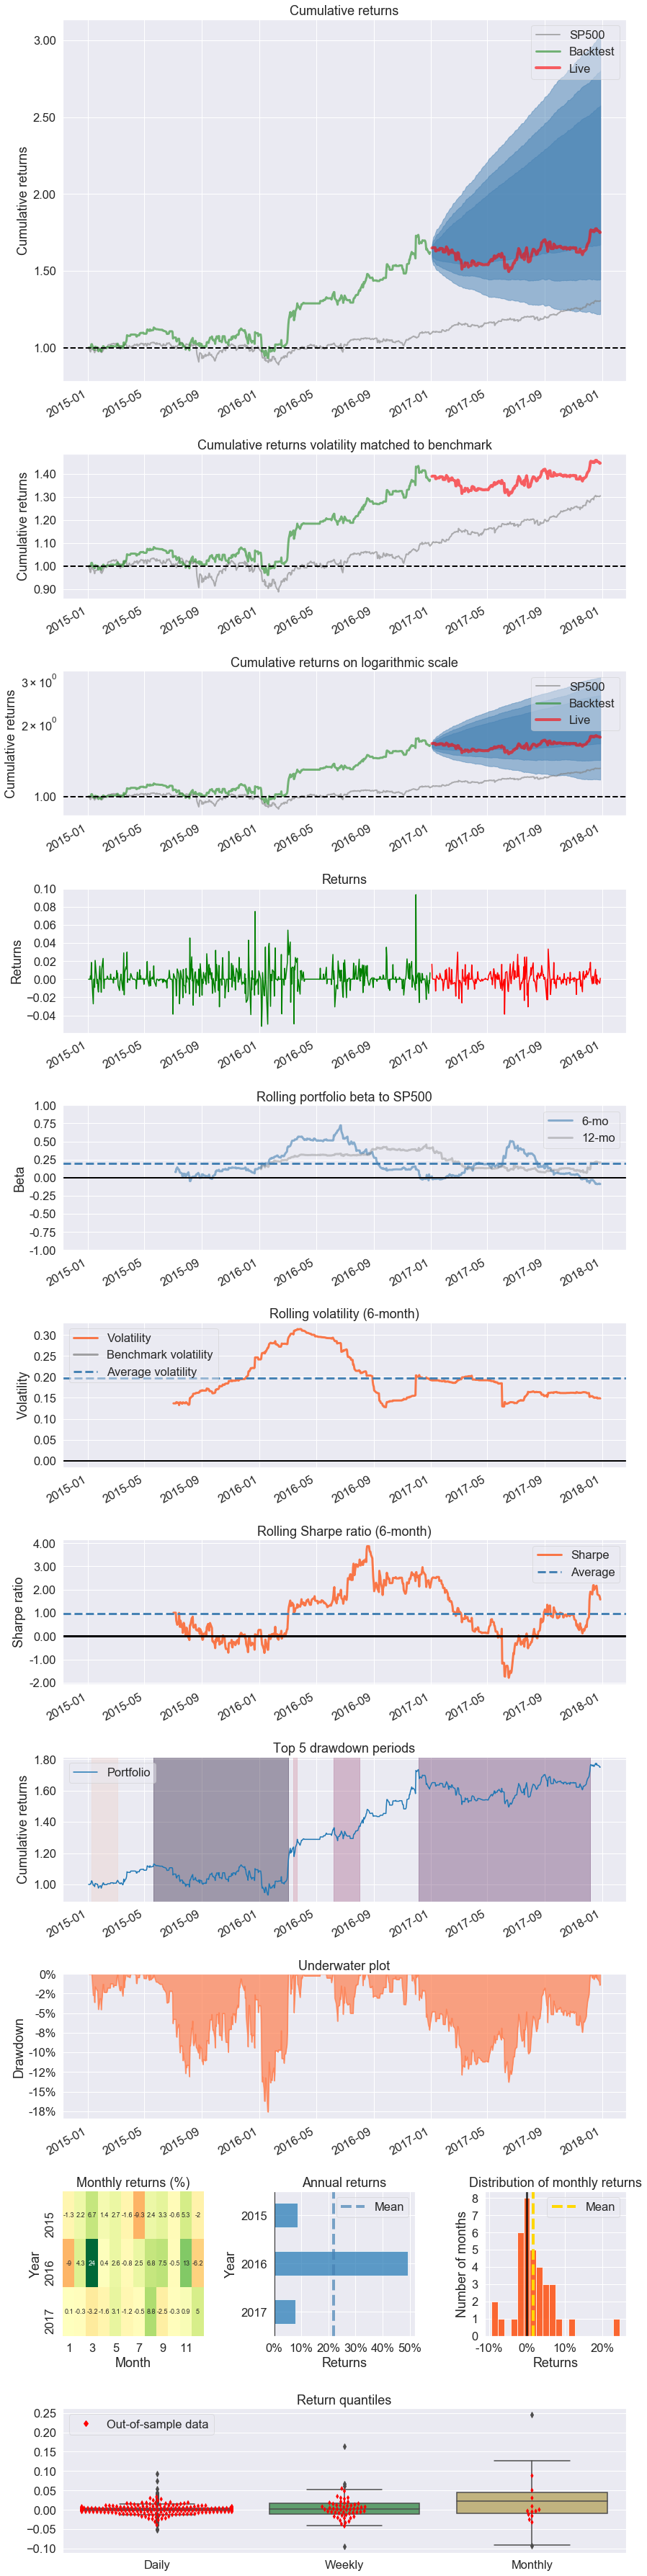

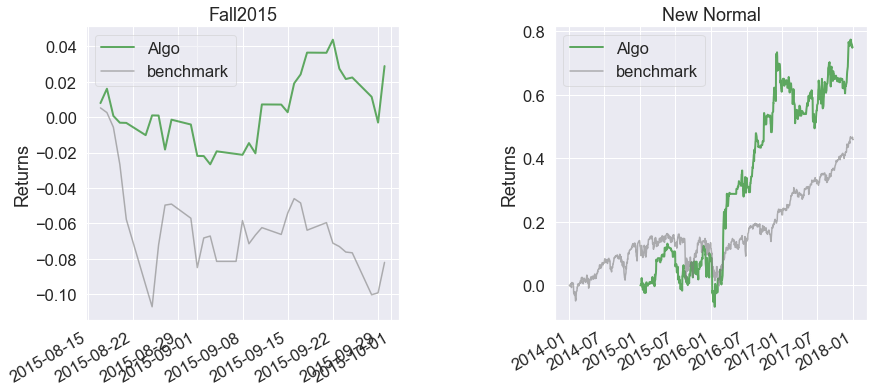

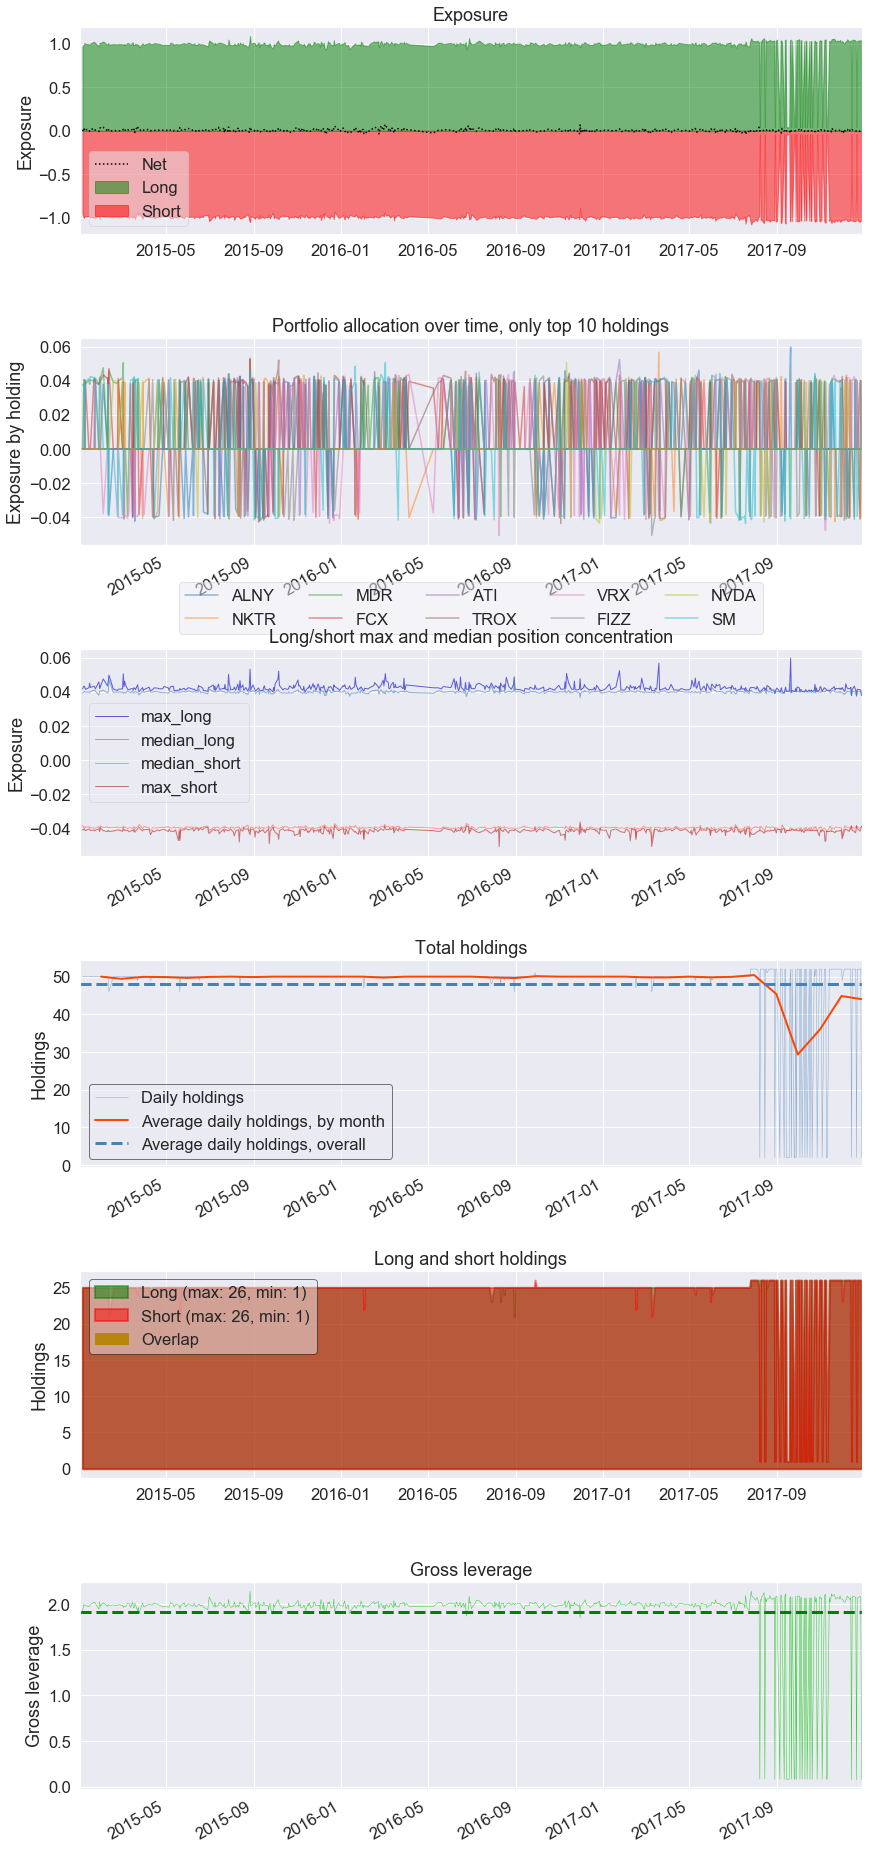

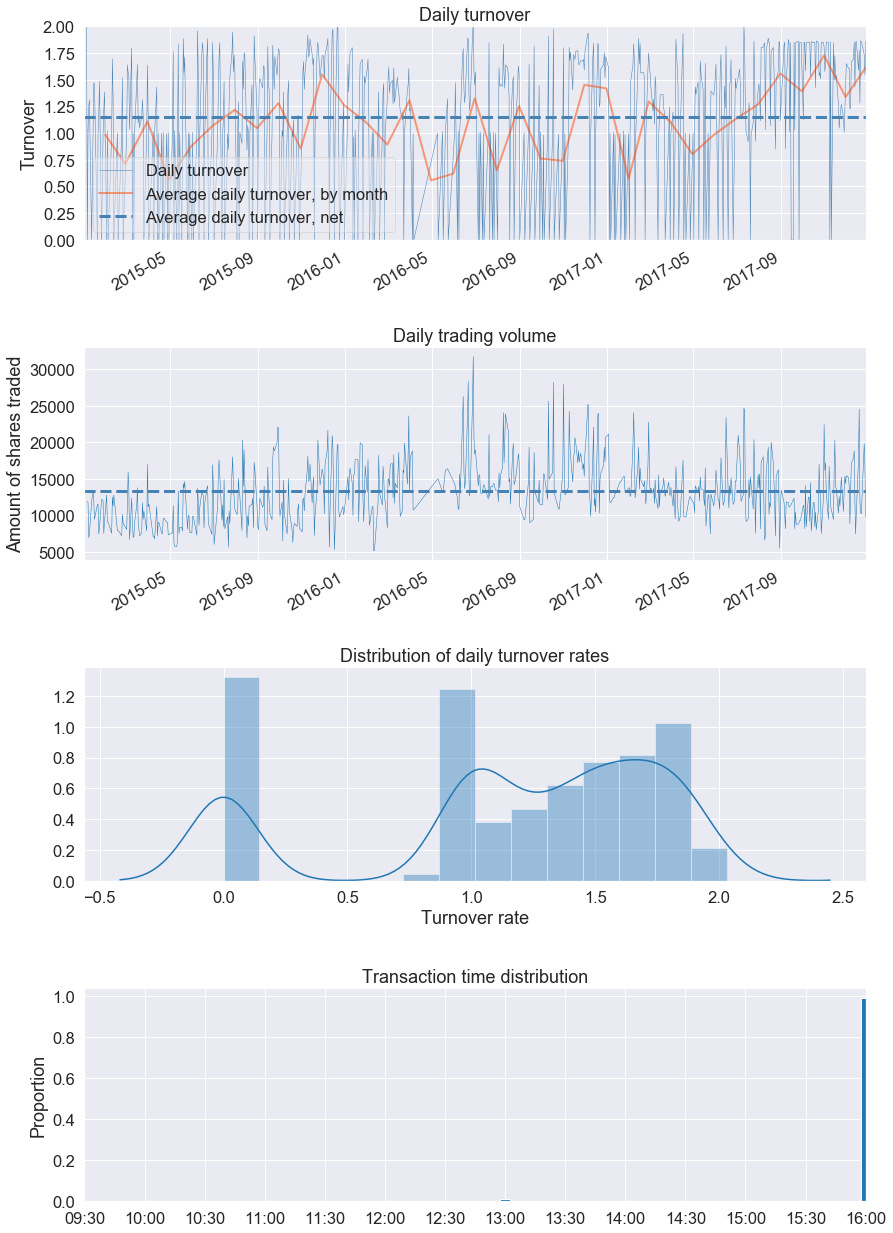

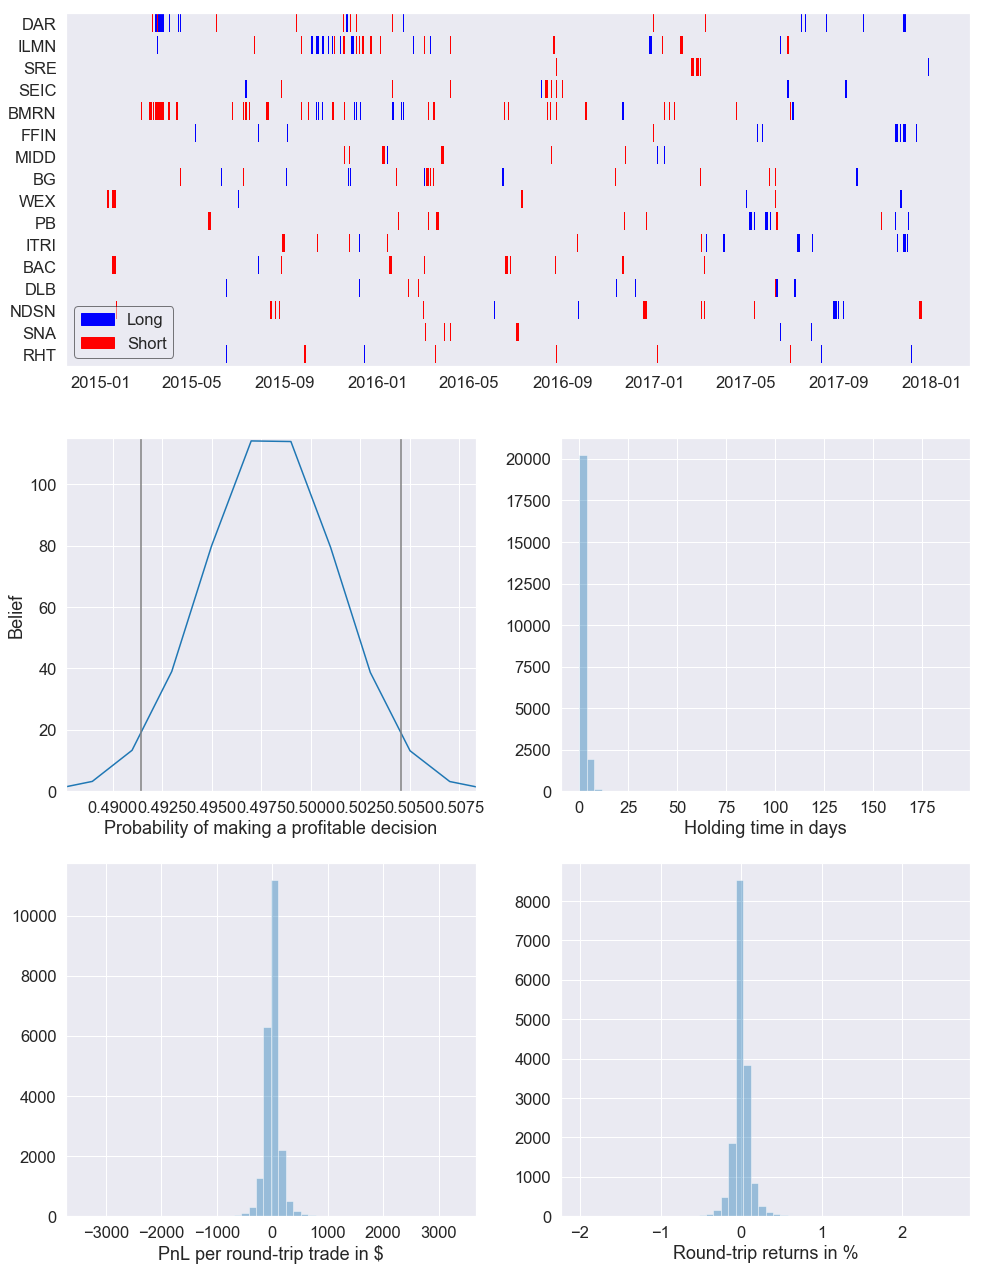

In [152]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)